
# 衛星画像データを取得する

この章では、衛星データの取得方法例を紹介します。衛星データは様々なところに散らばっており、そのようなデータを集めたものとして、Spatio Temporal Asset Catalog (STAC)が有名です。今回はSentinel-2を例として、オリジナルのデータ提供元からデータを取得する場合、STACから取得する場合の二つを挙げます。

始めに、サイトからの直接ダウンロードとsentinelsatのAPIを用いた衛星データの取得方法について触れ、最後に、STACからデータを入手する方法について説明します。

Source : http://apps.sentinel-hub.com/eo-browser/

最後に、本記事で実施する内容に関わりますが、アプリケーションプログラミングインタフェース(API)を利用することでデータを取得できるようになっています。APIは開発環境に左右されることなく、自身の開発環境からでも利用可能です。

SentinelのAPI詳細はこちらをご覧ください：https://scihub.copernicus.eu/userguide/

## 環境構築
必要となるライブラリをインストールします。

In [1]:
# Google Colab利用時
!pip install sentinelsat
!pip install rasterio
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install shapely
!pip install six
!pip install pyproj
!pip install geopandas
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 2.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of

## APIでSentinel-2の画像を取得する

### 関心領域の画像情報を取得する

In [2]:
import os, glob, re
from datetime import date
import numpy as np
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from osgeo import gdal
import json, geojson
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
import folium 
from PIL import Image
import earthpy.plot as ep

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 250

以下を実行し、ご自身が関心のある地域に移動し、図形を描画してください。
右クリックすることで点が打たれて図形になります。
図形を閉じるには実行画面右側にある「Close Shape」をクリックしてください。
例えば3回右クリックしたあとにClose Shapeを押すと四角形を描画できます。


In [3]:
# データを取得したい領域の座標情報を取得
from IPython.display import IFrame
src = 'https://www.keene.edu/campus/maps/tool/'
IFrame(src, width=960, height=500)

図形を描画したら下記でドラッグしている範囲の情報をコピーします。

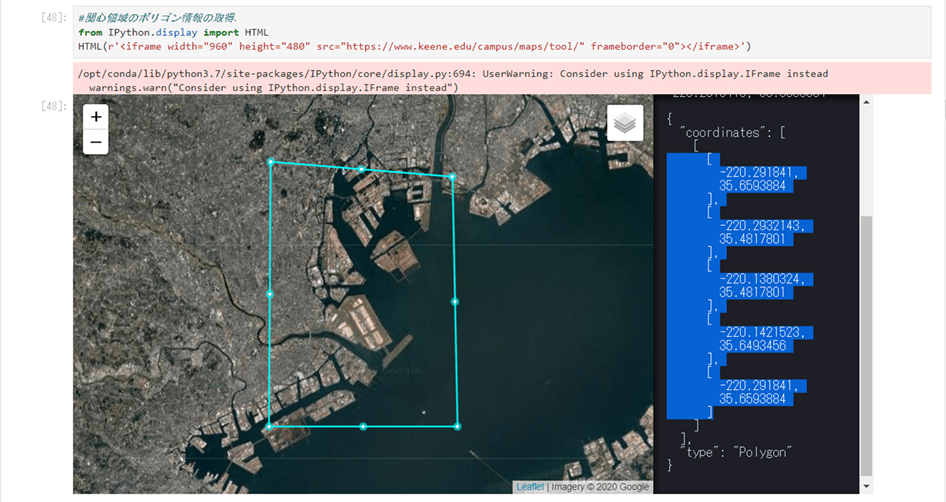

In [4]:
AREA =  [
      [
        -220.291841,
        35.6593884
      ],
      [
        -220.2932143,
        35.4817801
      ],
      [
        -220.1380324,
        35.4817801
      ],
      [
        -220.1421523,
        35.6493456
      ],
      [
        -220.291841,
        35.6593884
      ]
    ]

In [5]:
#左回りもしくは右回りに対応
for i in range(len(AREA)):
    if AREA[i][0] >= 0:
        AREA[i][0] = AREA[i][0]%360
    else:
        AREA[i][0] = -(abs(AREA[i][0])%360) + 360

In [6]:
AREA

[[139.708159, 35.6593884],
 [139.7067857, 35.4817801],
 [139.8619676, 35.4817801],
 [139.8578477, 35.6493456],
 [139.708159, 35.6593884]]

In [7]:
m = geojson.Polygon([AREA]) 

#ファイル名を定義. 好きな名称に設定してください. 
object_name = 'Tokyo_Bay'

with open(str(object_name) +'.geojson', 'w') as f:
    json.dump(m, f)
footprint_geojson = geojson_to_wkt(read_geojson(str(object_name) +'.geojson'))


In [11]:
# Sentinelからデータを取得するために、先ほど取得したSentinel Hubのユーザ情報を入力します
# ''は残した状態でusernameとpasswordを入力してください
user = 'username' 
password = 'password' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [12]:
# 定義した領域が合っているか、foliumの地図閲覧機能を用いて関心域を確認

m = folium.Map([(AREA[0][1]+AREA[len(AREA)-1][1])/2,(AREA[0][0]+AREA[len(AREA)-1][0])/2], zoom_start=10)

folium.GeoJson(str(object_name) +'.geojson').add_to(m)
m

In [18]:
# データの取得
# 過去のデータはアーカイブとなりこのまま取得できないため、
# 「データがオンラインではありません」というエラーが発生する場合には、
# 日付部分を適宜新しくした上で実行するようにしてください

products = api.query(footprint_geojson,
                     date = ('20221110', '20221120'), # 取得希望期間の入力
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,100)) # 被雲率（0％〜100％）

In [19]:
len(products)

2

In [20]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
bf476a98-b6e9-446a-8ae1-3a37d414197a,S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-11-18T01:29:41.024Z, Instrument: MS...",false,2022-11-18 04:30:56,2022-11-18 01:29:41.024,2022-11-18 01:29:41.024,2022-11-18 05:42:58.527,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_ATOS_20221118T043056_S2022...,S2A_OPER_MSI_L2A_TL_ATOS_20221118T043056_A0386...,S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_2...,bf476a98-b6e9-446a-8ae1-3a37d414197a,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."
9e6ffee1-d692-4400-ada5-0a634c330dbc,S2B_MSIL2A_20221113T012909_N0400_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-11-13T01:29:09.024Z, Instrument: MS...",false,2022-11-13 17:54:48,2022-11-13 01:29:09.024,2022-11-13 01:29:09.024,2022-11-14 02:14:27.649,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20221113T175448_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20221113T175448_A0297...,S2B_MSIL2A_20221113T012909_N0400_R074_T54SUE_2...,9e6ffee1-d692-4400-ada5-0a634c330dbc,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."


In [21]:
# 一覧で取得した画像を、被雲率が低い順に表示
products_gdf_sorted.head()

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
bf476a98-b6e9-446a-8ae1-3a37d414197a,S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-11-18T01:29:41.024Z, Instrument: MS...",false,2022-11-18 04:30:56,2022-11-18 01:29:41.024,2022-11-18 01:29:41.024,2022-11-18 05:42:58.527,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_ATOS_20221118T043056_S2022...,S2A_OPER_MSI_L2A_TL_ATOS_20221118T043056_A0386...,S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_2...,bf476a98-b6e9-446a-8ae1-3a37d414197a,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."
9e6ffee1-d692-4400-ada5-0a634c330dbc,S2B_MSIL2A_20221113T012909_N0400_R074_T54SUE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-11-13T01:29:09.024Z, Instrument: MS...",false,2022-11-13 17:54:48,2022-11-13 01:29:09.024,2022-11-13 01:29:09.024,2022-11-14 02:14:27.649,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20221113T175448_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20221113T175448_A0297...,S2B_MSIL2A_20221113T012909_N0400_R074_T54SUE_2...,9e6ffee1-d692-4400-ada5-0a634c330dbc,"MULTIPOLYGON (((138.80483 35.13500, 140.00972 ..."


In [22]:
# 検索したファイルがダウンロードできない場合があります。古いファイルはアーカイブとなってしまうためです
# アーカイブ化されたデータは、ダウンロード可能になるまで時間がかかるため、取得期間を現在に近いものに変えてダウンロードするようにしましょう

# ファイルが重いため、時間がかかります
uuid = products_gdf_sorted.iloc[0]["uuid"]
product_title = products_gdf_sorted.iloc[0]["title"]
api.download(uuid)

MD5 checksumming:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

{'id': 'bf476a98-b6e9-446a-8ae1-3a37d414197a',
 'title': 'S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_20221118T043056',
 'size': 1180934280,
 'md5': 'c4df6d9b7e3c3a3c171656f0db4f7440',
 'date': datetime.datetime(2022, 11, 18, 1, 29, 41, 24000),
 'footprint': 'POLYGON((138.77760353347315 36.12427601168043,139.99742868973178 36.14070199706385,140.00972076437196 35.15084307125522,138.80482996814663 35.13500195241116,138.77760353347315 36.12427601168043))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('bf476a98-b6e9-446a-8ae1-3a37d414197a')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 11, 18, 5, 43, 4, 550000),
 'Ingestion Date': datetime.datetime(2022, 11, 18, 5, 42, 58, 527000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('bf476a98-b6e9-446a-8ae1-3a37d414197a')/Products('Quicklook')/$value",
 'path': 'S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_20221118T043056.zip',
 'downloaded_bytes': 1180934280}

＊Product cecfe662-af60-4d0d-9c90-a4520ea58bb7 is not onlineと表示された場合には、対象のデータが既にアーカイブ化されていることを示します。

### 補足：Long Term Archive (LTA)について

Sentinelの過去データはLong Term Archive (LTA)とういオフラインプロダクトとなっており、そのままでは取得できません。Open Access Hubを利用する場合は上で言及したように、GUIを用いてオフラインのプロダクトをオンラインにするように申請することができます。sentinelsatでは同様のことをAPI経由で行うことになります。

LTAプロダクトをオンラインにするためには、`trigger_offline_retrieval(uuid)`を利用します。まずは、対象としているデータがオンラインなのか、オフラインかを確認してみましょう。意図的に古いデータを取得してみます。



In [23]:
ltaProducts = api.query(footprint_geojson,
                     date = ('20191001', '20191201'), # 取得希望期間の入力
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,30)) # 被雲率（0％〜30％）

`get_product_odata(uuid)`を用いて、対象のメタデータを取得します。`Online`というキーはTrueとFalseの値を持ち、Falseの場合、対象のデータがオフラインになっていることを示しています。

In [24]:
len(ltaProducts)

6

In [25]:
ltaProducts_gdf = api.to_geodataframe(ltaProducts)
# api.get_product_odata(ltaProducts_gdf.index[0])
api.get_product_odata(ltaProducts_gdf.index[0])['Online'] # False or True

False

In [26]:
offLineID = ltaProducts_gdf.index[0]
is_online = api.is_online(offLineID)

if is_online:
    print(f'Product {offLineID} is online. Starting download.')
    api.download(offLineID)
else:
    print(f'Product {offLineID} is not online.')
    api.trigger_offline_retrieval(offLineID)

Product b5d38025-c882-48aa-bd08-bf6706ecf9cf is not online.


値がTrueで返ってくると、オンライン化の申請を送信できたということになります。実際にダウンロードするまでには、最大で24時間程度かかります。ある程度時間が経過したら、再び`download(uuid)`を試してください。

下のように複数のオフラインプロダクトに対して申請を行うことも可能です。

In [27]:
years = [2017,2018]

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

for iyear in years:
  footprint = geojson_to_wkt(read_geojson('/content/Tokyo_Bay.geojson')) 
  products = api.query(footprint, 
                       date=('{}0101'.format(iyear),'{}0201'.format(iyear)),
                       platformname='Sentinel-2',
                       cloudcoverpercentage=(0,20))
      
  products_df = api.to_dataframe(products) # 取得したプロダクトの情報をデータフレームへ
  count = len(products)
  print('For the year {year}, {num} imagery(ies) were found.'.format(year=iyear,num=count))
  products_df_sorted = products_df.sort_values(['cloudcoverpercentage', 'ingestiondate'],ascending=[True, True]) # 雲量とingestiondate(プロダクトがデータベースに格納された時間)で並び替え
    
  for steps in range(count):
    if os.path.exists(products_df_sorted['filename'].values[0]):
      print(products_df_sorted['filename'].values[0]," already exists. Skipping")
      continue
    sceneId = products_df_sorted.index[steps]
    product_info = api.get_product_odata(sceneId)
    if product_info['Online']:
      print('Product {} is online. Starting download.'.format(sceneId))
      api.download(sceneId)
    else:
      print('Product {} is not online. Please try again later.'.format(sceneId))
      try:
        # api.download(sceneId)
        print(api.trigger_offline_retrieval(sceneId))
        # Trueならば、オンライン化申請が成功。Falseの場合は、すでにオンラインになっている
      except:
        pass
  print('\n\n')

For the year 2017, 2 imagery(ies) were found.
Product c1620b63-b95b-498e-a522-9a4511ddc0fc is not online. Please try again later.
True
Product 616c69eb-de61-4157-bed4-548fb8a0b42b is not online. Please try again later.
True



For the year 2018, 3 imagery(ies) were found.
Product 313b916c-ea9c-44d2-9ff8-853a48827e60 is not online. Please try again later.
True
Product b270b6c5-b578-4bca-87e7-8ffc72060091 is not online. Please try again later.
True
Product b838d1cd-4767-470c-aab2-21df7d408a82 is not online. Please try again later.
True





### 関心域の画像を抽出する

rasterioを用いて、取得したSentinel-2の観測画像を確認します。今回は、Sentinel-2のBand4,3,2によるTrue Imageを作成しましょう。

In [28]:
os.path.join(os.getcwd(),product_title) +  ".SAFE"

'/content/S2A_MSIL2A_20221118T012941_N0400_R074_T54SUE_20221118T043056.SAFE'

In [29]:
file_name = str(product_title) +'.zip'
import zipfile
with zipfile.ZipFile(file_name) as zf:
  zf.extractall()

# SAFEファイルの場所をfilePathに入れます
# jp2という画像ファイルが入っているフォルダはディレクトリの深い場所にあるため、以下のように分けています
# jp2が入っているディレクトリは以下の通りです
# /content/S2A_MSIL2A_20210805T012701_N0301_R074_T54SUE_20210805T035144.SAFE/GRANULE/L2A_T54SUE_A031960_20210805T012658/IMG_DATA/R10m
filePath = os.path.join(os.getcwd(),product_title) +  ".SAFE" # SAFEファイルの場所指定

path = os.path.join(filePath, 'GRANULE')
files = os.listdir(path)

pathA = os.path.join(filePath,'GRANULE',str(files[0]))
files2 = os.listdir(pathA)

pathB = os.path.join(filePath, 'GRANULE', str(files[0]),'IMG_DATA/R10m')
files3 = os.listdir(pathB)

画像を作るために、バンドを指定します。今回はバンド2をRに、バンド3をGに、バンド4をBに割り当てます。

In [30]:
fileNameList = glob.glob(pathB+'/*.jp2')
path_b2 = list(filter(lambda x: x.endswith('B02_10m.jp2'),fileNameList))[0]
path_b3 = list(filter(lambda x: x.endswith('B03_10m.jp2'),fileNameList))[0]
path_b4 = list(filter(lambda x: x.endswith('B04_10m.jp2'),fileNameList))[0]

バンド4の画像を対象に、画像サイズや座標系を確認します。

In [31]:
b4 = rio.open(path_b4) # red
b3 = rio.open(path_b3) # green
b2 = rio.open(path_b2) # blue

b4.count, b4.width, b4.height

b4.crs

CRS.from_epsg(32654)

今回の例の場合は、サイズは（1, 10980, 10980）、座標系はCRS.from_epsg (32654)と表示されました。10980はピクセル数を表し、Sentinelは解像度が10 mGSD(つまり1ピクセルが10 m)なので、一辺が10980 pixel × 10 m/pixel、およそ100 kmの画像であることが分かります。EPSGの32654というのは、UTM座標系（UTM-54）のことを表します。座標系については、この後の節で説明をします。

In [32]:
with rio.open(str(object_name) +'.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),3) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),1) 
    rgb.close()

RGB_tokyo =rio.open(str(object_name) +'.tiff')
RGB_tokyo.crs

nReserve_geo = gpd.read_file(str(object_name) +'.geojson')
epsg = b4.crs

このまま画像をダウンロードしてもよいのですが、このファイルは見たい範囲以外も含んだSentinel-2の1シーンの画像となっています。ファイルサイズも大きいため、関心領域のみを抽出してダウンロードした方が効率的です。そのため、以下で抽出していきます。

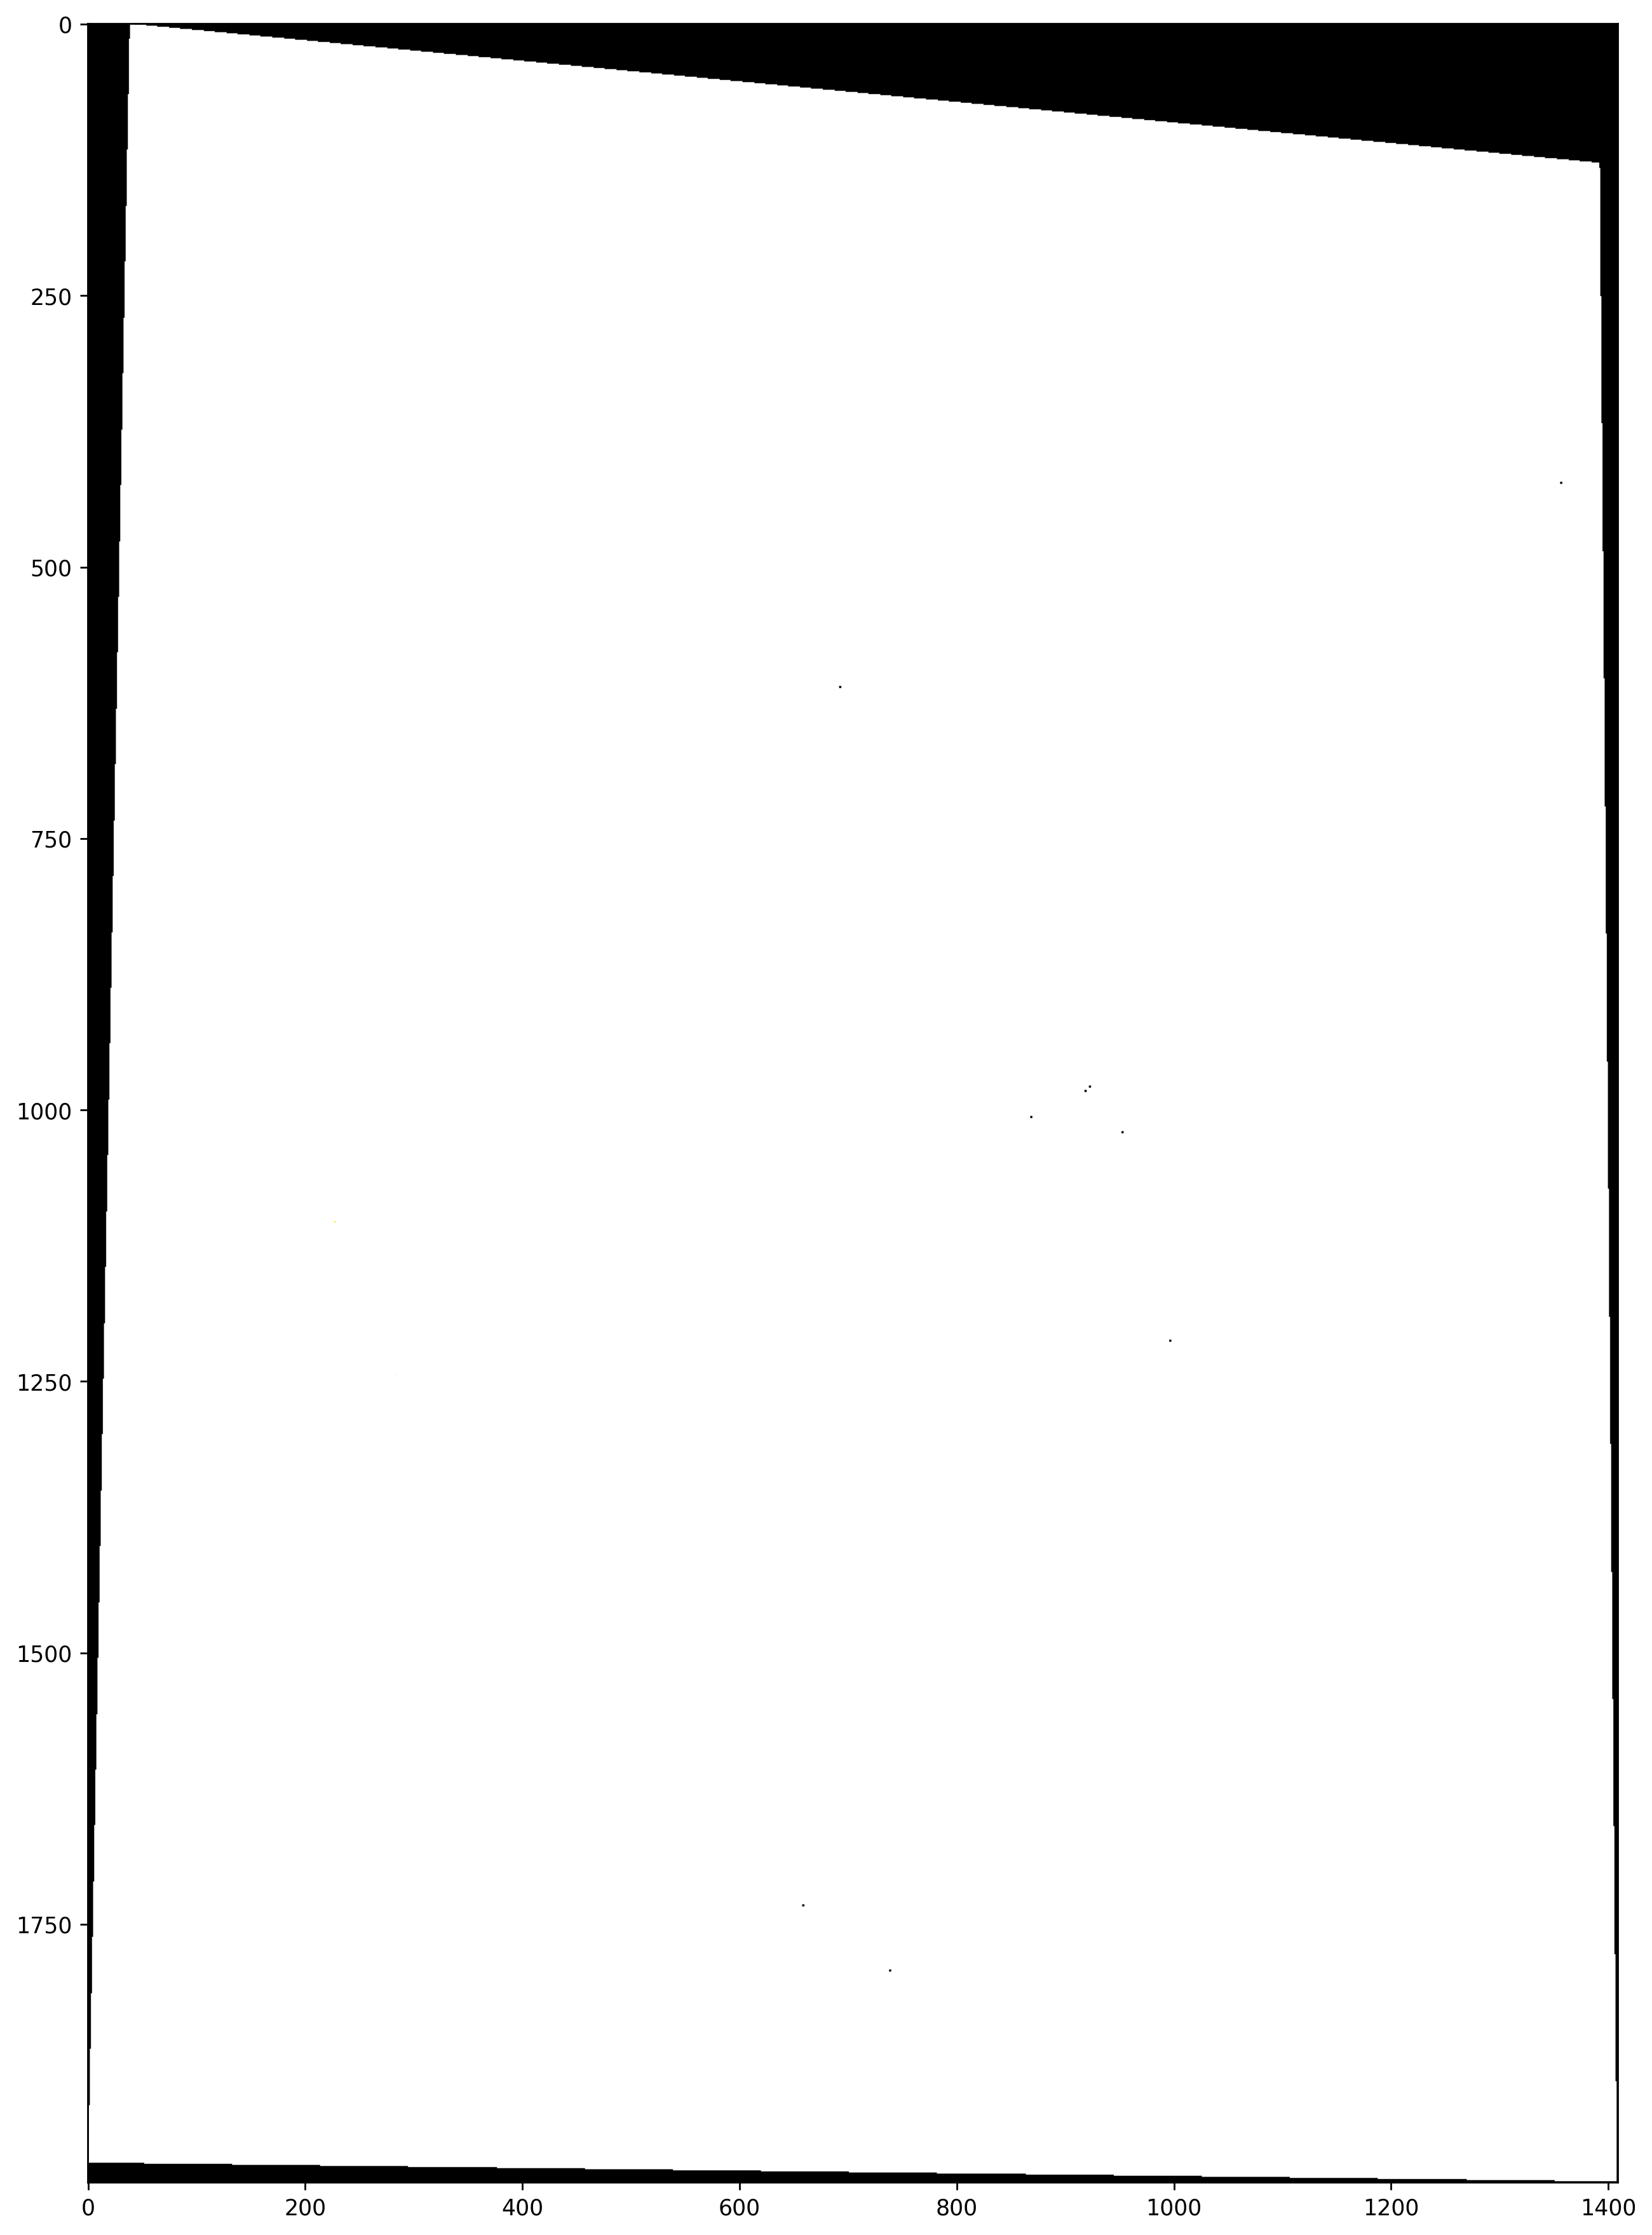

In [33]:
nReserve_proj = nReserve_geo.to_crs({'init': epsg})

with rio.open(str(object_name) +'.tiff') as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open('Masked_' +str(object_name) +'.tif', "w", **out_meta) as dest:
    dest.write(out_image)

msk = rio.open(r'Masked_' +str(object_name) +'.tif')
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show();

実行すると、上記のような画像が描画されると思います。画像自体は16ビットな中で、8ビットの画像として自動でヒストグラムを調整し、描画するため、このような見た目となります。続いては、画像の見た目を調整します（変換後のピクセル値が255の方へと偏っているため白っぽい見た目になっています）。

In [34]:
imgTif = 'Masked_' +str(object_name) +'.tif' # 読み出し用Tiffのパス
imgJpg = 'Masked_' +str(object_name) +'.jpg' # 書き出し用jpgのパスs


with rio.open(imgTif) as src:
  img_array = src.read() # 配列情報の読み取り

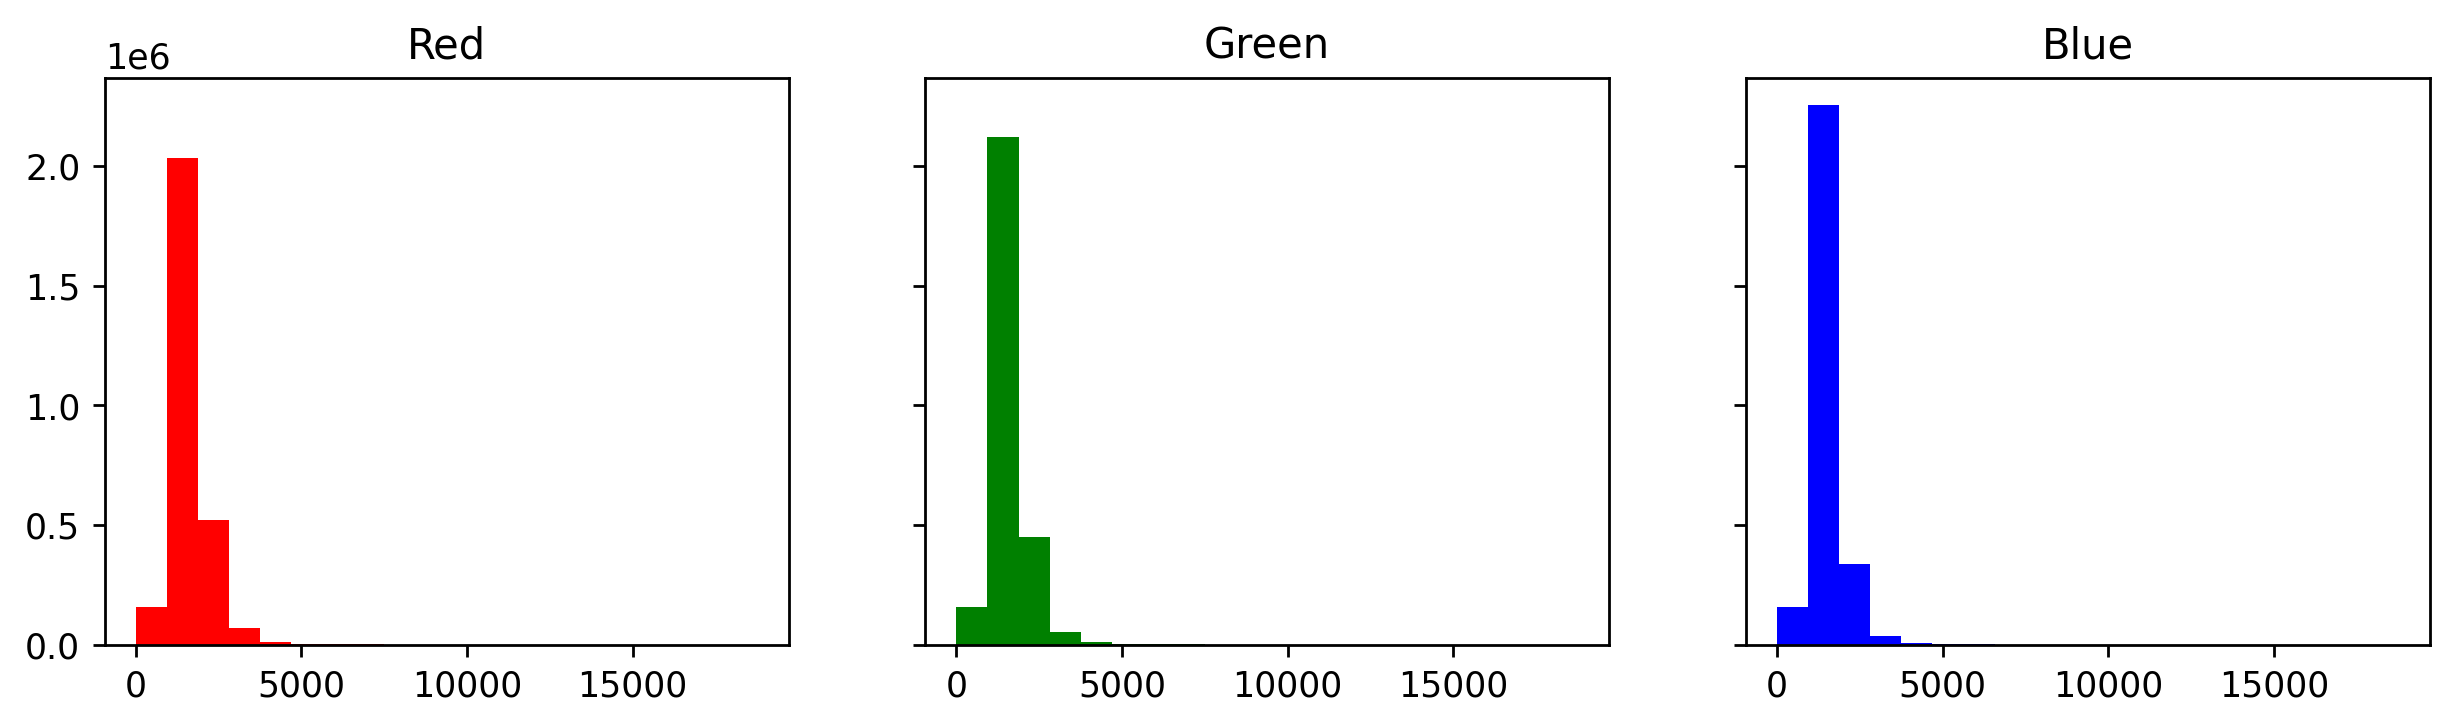

In [35]:
# 各々のピクセル値の分布をヒストグラムとして描画
# eathpyを利用
ep.hist(img_array,
        colors=['r', 'g', 'b'],
        title=['Red', 'Green', 'Blue'],
        cols=3,
        figsize=(12, 3));

上のヒストグラムを見てわかるように、分布がゼロに偏り気味です。おおよその分布が0から3000辺りにあるため、この範囲で8bitのJpeg画像へと変換します。変換には`gdal.Translate`を利用します。

In [36]:
gdal.Translate(imgJpg, imgTif, format='JPEG', scaleParams=[[0,3000,0,255]])
# scaleParamsの部分は空白[[]]でも動作します。その場合は、gdal.Translateが自動で最適なコントラストに設定しますが、多くの場合手動でやるほうが良い結果になります
im = Image.open('Masked_' +str(object_name) +'.jpg')
im

## やや長いですが、下記方法でも変換可能です（より厳密な定義）
# scale = '-scale 0 3000 0 255' # 画像の色調整を行います(16bitから8bit範囲へ変換)
# options_list = [
#     '-ot Byte', # 8bitまで扱う
#     '-of JPEG', # 変換後の画像フォーマット
#     scale # 画像のコントラスト
# ] 
# options_string = " ".join(options_list)

# gdal.Translate(imgJpg, # 変換後の画像（パスごと記入）
#                imgTif, # 変換元の画像
#                options=options_string) # オプション指定


Output hidden; open in https://colab.research.google.com to view.

画像の明るさを調整しつつ、興味範囲の画像を取得できました。

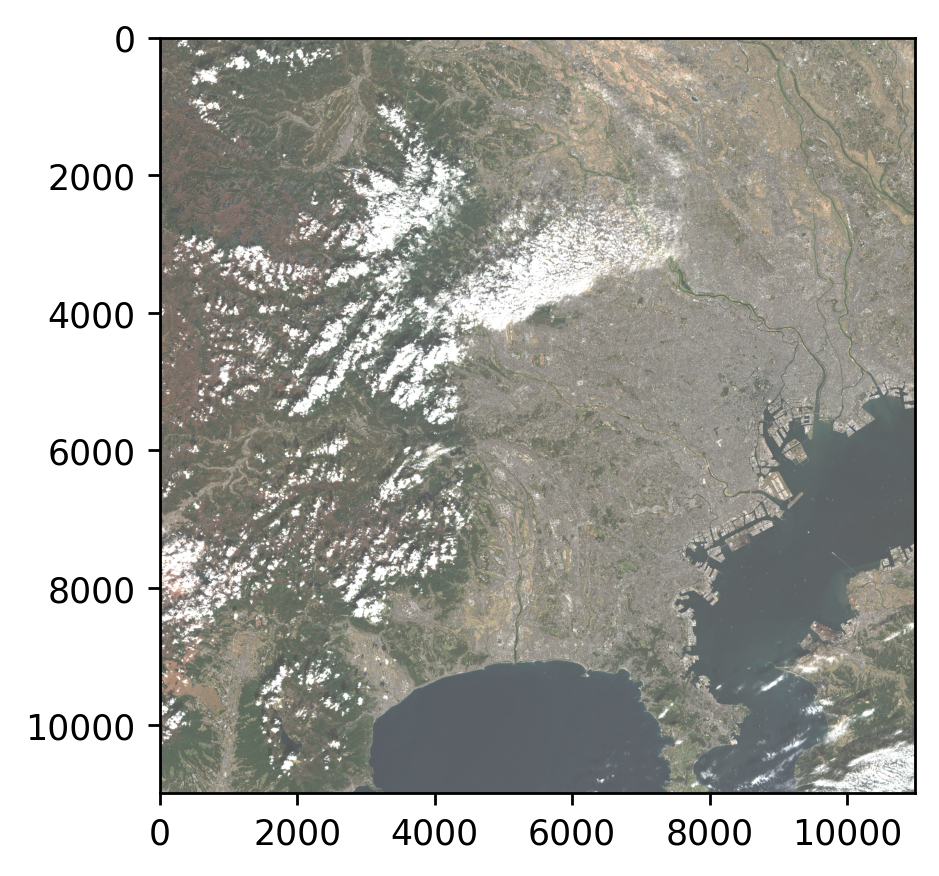

In [37]:
# rio.openされたjp2ファイルを配列化
b, g, r = b2.read(1), b3.read(1), b4.read(1)
imgArray = np.array([r, g, b])

# RGB画像の最大値を調整（見た目を良くする作業）
imgArray[imgArray > 3000] = 3000
img = ((imgArray / imgArray.max()) * 255).astype(np.uint8)
rio.plot.show(img)

なお、Sentinelのデータポリシーについては下記に公開されています。

https://sentinel.esa.int/web/sentinel/terms-conditions

今回は画像を出力しているので「produced from ESA remote sensing data」と記載しています。

## Spatio temporal Asset Catalog (STAC)を利用する

In [38]:
# Colab利用時には以下のコマンドを実行してください（初回のみ）
!apt-get install -y libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
libspatialindex-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [39]:
# STACを利用するために、改めてライブラリのインストールを行います
# Colab利用時にはインストール後ランタイムを再起動してください
!pip install cartopy
!pip install pygeos
!pip install rtree
!pip install sat-search
!pip install pystac-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.9 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 22.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 58.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 31.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 38.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 14.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing w

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 146 kB 10.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [40]:
# ライブラリのインポート
import os, json
from shapely.geometry import MultiPolygon, Polygon, box
from fiona.crs import from_epsg
import numpy as np
from satsearch import Search
from pystac_client import Client
from io import BytesIO
import urllib
from PIL import Image
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import warnings
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from osgeo import gdal
warnings.filterwarnings('ignore')

print("done")


done


In [41]:
AREA =  [
      [
        -220.291841,
        35.6593884
      ],
      [
        -220.2932143,
        35.4817801
      ],
      [
        -220.1380324,
        35.4817801
      ],
      [
        -220.1421523,
        35.6493456
      ],
      [
        -220.291841,
        35.6593884
      ]
    ]

#左回りもしくは右回りに対応
for i in range(len(AREA)):
    if AREA[i][0] >= 0:
        AREA[i][0] = AREA[i][0]%360
    else:
        AREA[i][0] = -(abs(AREA[i][0])%360) + 360

In [42]:
# AREAから最小緯度・経度、最大緯度・経度を取得します
areaLon = []
areaLat = []
# iterating each number in list
for coordinate in AREA:
  areaLon.append(coordinate[0])
  areaLat.append(coordinate[1])

minLon = np.min(areaLon) # min longitude
maxLon = np.max(areaLon) # max longitude
minLat = np.min(areaLat) # min latitude
maxLat = np.max(areaLat) # max latitude

In [43]:
# 取得範囲を指定するための関数を定義
def selSquare(minLon, minLat, maxLon, maxLat):
   c1 = [maxLon, maxLat]
   c2 = [maxLon, minLat]
   c3 = [minLon, minLat]
   c4 = [minLon, maxLat]
   geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
   return geometry

In [44]:
bbox = selSquare(minLon, minLat, maxLon, maxLat) # 画像取得範囲の設定 min lon, min lat, max lon, max lat
dates = '2021-04-10/2021-06-10' # '20210410', '20210610'

from pystac_client import Client
api_url = 'https://earth-search.aws.element84.com/v0'
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A (BOA)
s2STAC = Client.open(api_url, headers=[])


s2Search = s2STAC.search (
   intersects = bbox,
   datetime = dates,
   query = {"eo:cloud_cover": {"lt": 20}, "sentinel:valid_cloud_cover": {"eq": True}},
   collections = collection)

s2_items = [i.to_dict() for i in s2Search.get_items()]
print(f"{len(s2_items)} のシーンを取得")

2 のシーンを取得


In [45]:
items = s2Search.get_all_items()
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
# 雲量で並び替え
dfSorted = df.sort_values('eo:cloud_cover').reset_index(drop=True)
dfSorted.head()

,geometry,datetime,platform,constellation,instruments,gsd,view:off_nadir,proj:epsg,sentinel:utm_zone,sentinel:latitude_band,sentinel:grid_square,sentinel:sequence,sentinel:product_id,sentinel:data_coverage,eo:cloud_cover,sentinel:valid_cloud_cover,created,updated
0,"POLYGON ((138.80484 35.13501, 138.77761 36.124...",2021-04-27T01:37:19Z,sentinel-2a,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2A_MSIL2A_20210427T012651_N0300_R074_T54SUE_2...,100,8.43,True,2021-04-27T07:07:07.195Z,2021-04-27T07:07:07.195Z
1,"POLYGON ((138.80484 35.13501, 138.77761 36.124...",2021-06-01T01:37:23Z,sentinel-2b,sentinel-2,[msi],10,0,32654,54,S,UE,0,S2B_MSIL2A_20210601T012659_N0300_R074_T54SUE_2...,100,11.46,True,2021-06-01T06:54:18.880Z,2021-06-01T06:54:18.880Z


サムネイルで画像を確認して見ましょう。

In [46]:
# 最も雲の量が少ないシーンを選択し、サムネイル画像も取得する関数を定義します。
def sel_items(scene_items, product_id):
 item = [x.assets for x in scene_items\
         if x.properties['sentinel:product_id'] == product_id]
 thumbUrl = [x.assets['thumbnail'].href for x in scene_items\
             if x.properties['sentinel:product_id'] == product_id]
 return item, thumbUrl

selected_item, thumbUrl = sel_items(items, dfSorted['sentinel:product_id'][0])
print(thumbUrl)
print(selected_item)

['https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/54/S/UE/2021/4/27/0/preview.jpg']
[{'thumbnail': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/54/S/UE/2021/4/27/0/preview.jpg>, 'overview': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2A_54SUE_20210427_0_L2A/L2A_PVI.tif>, 'info': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/54/S/UE/2021/4/27/0/tileInfo.json>, 'metadata': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/54/S/UE/2021/4/27/0/metadata.xml>, 'visual': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2A_54SUE_20210427_0_L2A/TCI.tif>, 'B01': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2A_54SUE_20210427_0_L2A/B01.tif>, 'B02': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2A_54SUE_20210427_0_L2A/B02.tif>, 'B03': <Asse

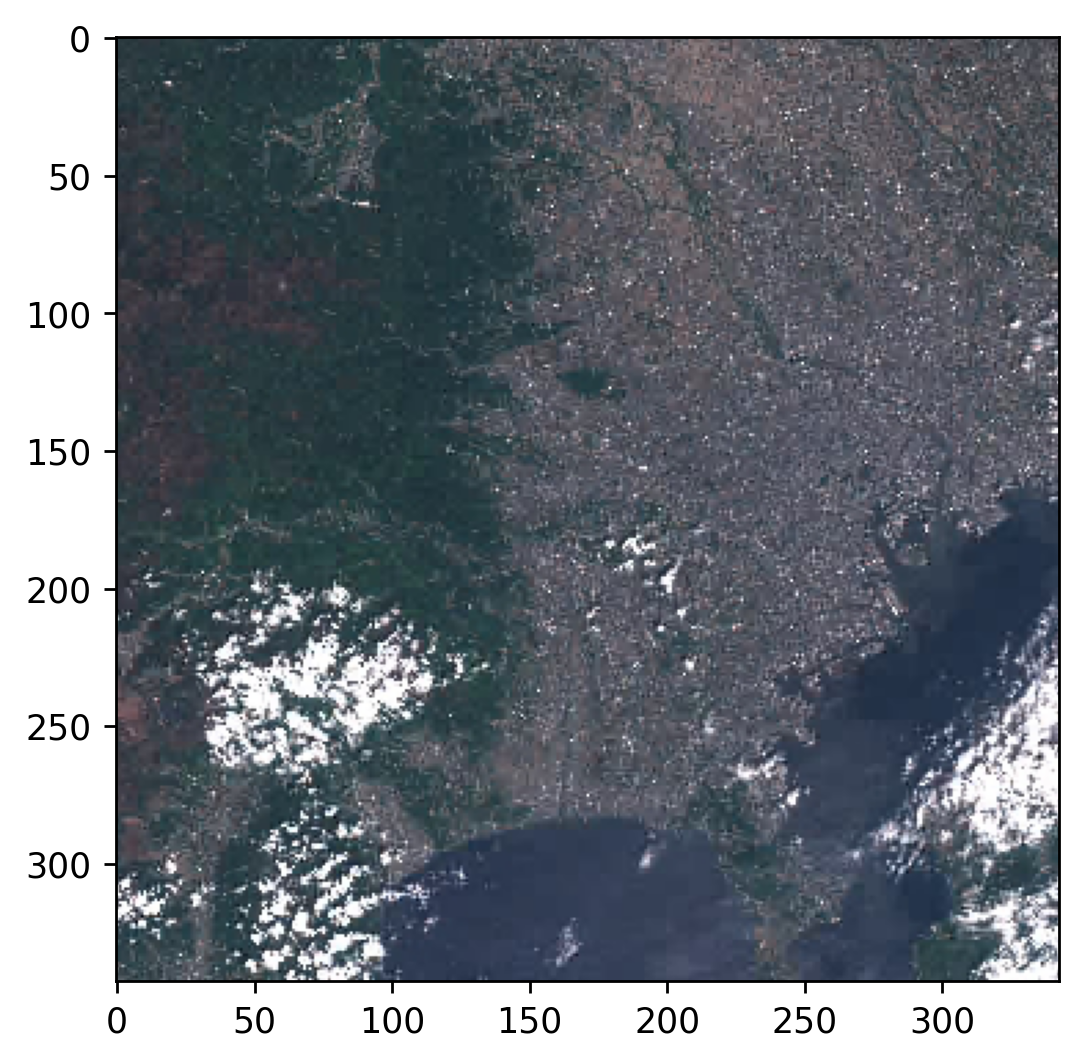

In [47]:
thumbImg = Image.open(BytesIO(requests.get(thumbUrl[0]).content))
plt.figure(figsize=(5,5))
plt.imshow(thumbImg)

In [48]:
items[0].assets['B02']

href: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/6/S2B_54SUE_20210601_0_L2A/B02.tif
Title: Band 2 (blue)
Media type: image/tiff; application=geotiff; profile=cloud-optimized
Roles: ['data']
Owner:
gsd: 10
"eo:bands: [{'name': 'B02', 'common_name': 'blue', 'center_wavelength': 0.4966, 'full_width_half_max': 0.098}]"
"proj:shape: [10980, 10980]"
"proj:transform: [10, 0, 300000, 0, -10, 4000020, 0, 0, 1]"


それではファイルのURLを取得しましょう。URLはメタデータ内に記載されています。

In [49]:
# 引用：https://note.nkmk.me/python-download-web-images/
def download_file(url, dst_path):
   try:
       with urllib.request.urlopen(url) as web_file, open(dst_path, 'wb') as local_file:
           local_file.write(web_file.read())
   except urllib.error.URLError as e:
       print(e)

def download_file_to_dir(url, dst_dir):
   download_file(url, os.path.join(dst_dir, os.path.basename(url)))

In [50]:
# 画像の作成フォルダを作成
os.makedirs('sentinel2COG',exist_ok=True)
RGB_dir = "/content/sentinel2COG"

# 取得するバンドの選択
bandLists = ['B04','B03','B02'] # RED, GREEN, BLUE

# 画像のURL取得
file_url = []
[file_url.append(selected_item[0][band].href) for band in bandLists if file_url.append(selected_item[0][band].href) is not None]

# 画像のダウンロード
[download_file_to_dir(link, RGB_dir) for link in file_url if download_file_to_dir(link, RGB_dir) is not None]

[]

In [51]:
file_url

['https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2A_54SUE_20210427_0_L2A/B04.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2A_54SUE_20210427_0_L2A/B03.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/S/UE/2021/4/S2A_54SUE_20210427_0_L2A/B02.tif']

In [52]:
# 参照：https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
# bboxの値はそのままで利用できないため、以下のコードを用いて変換を行います

bbox = box(minLon, minLat, maxLon, maxLat)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326)) # WGS84座標系を指定
geo = geo.to_crs(crs='epsg:32654') # Sentinel-2の画像に合わせます

def getFeatures(gdf):
    """rasterioで読み取れる形のデータに変換するための関数です"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[396762.7785510754, 3927067.932522922], [396990.4148314546, 3946767.1466804133], [382943.32116527937, 3946940.915480255], [382684.6295948352, 3927241.3322548624], [396762.7785510754, 3927067.932522922]]]}]


トゥルーカラー画像を作成します。

In [53]:
# 画像の読み込み
b2 = rio.open(file_url[2])
b3 = rio.open(file_url[1])
b4 = rio.open(file_url[0])

# 出力ファイル名
RGB_path = os.path.join(RGB_dir,'sentinel-2_l2a-cogs'+'.tif')
  
# GeoTIFFの作成
RGB_color = rio.open(RGB_path,'w',driver='Gtiff', # driverにGtiff(GeoTIFF)
    width=b4.width, height=b4.height, # 画像の高さや幅を指定。B04のバンドと同じ大きさにしています
    count=3, # 3つのバンドを利用 (B02, B03, B04)
    crs=b4.crs, # crsもB04と同様。epsg:32654
    transform=b4.transform, # データに対する変換も同様のもの
    dtype=rio.uint16 # データ型を指定
    )
# 各々のバンド情報をRGB_colorに書き込み
RGB_color.write(b2.read(1),3) # 青
RGB_color.write(b3.read(1),2) # 緑
RGB_color.write(b4.read(1),1) # 赤
RGB_color.close()

with rio.open(RGB_path) as src:
  out_image, out_transform = mask(src, coords, crop=True) #mask処理の実行
  out_meta = src.meta # 作成する画像の情報はもともとの画像と同様のものにします

# メタ情報の更新
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# 画像の書き出し
with rio.open(RGB_path, "w", **out_meta) as dest:
  dest.write(out_image)

# 画像表示のため8bit形式で書き出し。画像の色味も調整します
scale = '-scale 0 255 0 25'
options_list = ['-ot Byte','-of Gtiff',scale]
options_string = " ".join(options_list)

gdal.Translate(os.path.join(RGB_dir,'sentinel-2_l2a-cogs_Masked'+'.tif'),os.path.join(RGB_dir,'sentinel-2_l2a-cogs'+'.tif'),options = options_string)

print("done")

done


画像と切り出す用のベクターファイル（ここではcoords）のCRSが合わないと、エラーが発生します。取得した画像のCRSを忘れにずにチェックするようにしましょう。`item.metadata['proj:epsg']`で確認することができます。

In [54]:
plt.figure(figsize=(6,10))
RGB_2017OctCOG = rio.open('/content/sentinel2COG/sentinel-2_l2a-cogs_Masked.tif')
show(RGB_2017OctCOG.read([1,2,3]))

Output hidden; open in https://colab.research.google.com to view.